# Spark DataFrames & SQL - Interactive Learning Notebook

Welcome to Lesson 2 of the Spark Bootcamp! This notebook provides hands-on experience with Spark DataFrames and SQL operations.

## Learning Objectives

By the end of this notebook, you will:
- Understand DataFrame fundamentals and advantages over RDDs
- Create DataFrames from various sources
- Perform data transformations and aggregations
- Use Spark SQL for complex queries
- Apply window functions and analytics
- Optimize performance with caching and query plans

## Section 1: Setting Up Spark DataFrame Environment

In [1]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create Spark session
spark = SparkSession.builder \
    .appName("DataFrames-Learning") \
    .master("local[*]") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

print(f"Spark version: {spark.version}")
print(f"Spark context available: {spark.sparkContext is not None}")

25/10/01 16:28:44 WARN Utils: Your hostname, Liams-MacBook-Pro.local resolves to a loopback address: 127.0.2.2; using 192.168.1.240 instead (on interface en0)
25/10/01 16:28:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/01 16:28:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 3.5.7
Spark context available: True


## Section 2: DataFrame Creation Fundamentals

Let's start by creating DataFrames using different methods.

In [2]:
# Method 1: Create DataFrame from Python data structures
employee_data = [
    ("Alice Johnson", 28, "Engineering", 85000),
    ("Bob Chen", 34, "Marketing", 65000),
    ("Charlie Davis", 29, "Engineering", 78000),
    ("Diana Rodriguez", 31, "Sales", 72000),
    ("Eve Wilson", 26, "Engineering", 92000)
]

columns = ["name", "age", "department", "salary"]
employees_df = spark.createDataFrame(employee_data, columns)

print("DataFrame created from list of tuples:")
employees_df.show()
employees_df.printSchema()

DataFrame created from list of tuples:


+---------------+---+-----------+------+
|           name|age| department|salary|
+---------------+---+-----------+------+
|  Alice Johnson| 28|Engineering| 85000|
|       Bob Chen| 34|  Marketing| 65000|
|  Charlie Davis| 29|Engineering| 78000|
|Diana Rodriguez| 31|      Sales| 72000|
|     Eve Wilson| 26|Engineering| 92000|
+---------------+---+-----------+------+

root
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)
 |-- department: string (nullable = true)
 |-- salary: long (nullable = true)



In [3]:
# Method 2: Create DataFrame with explicit schema
schema = StructType([
    StructField("name", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("department", StringType(), True),
    StructField("salary", IntegerType(), True)
])

employees_typed_df = spark.createDataFrame(employee_data, schema)

print("DataFrame with explicit schema:")
employees_typed_df.printSchema()
print(f"Row count: {employees_typed_df.count()}")

DataFrame with explicit schema:
root
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- salary: integer (nullable = true)

Row count: 5


In [4]:
# Method 3: Create DataFrame from dictionaries
product_dicts = [
    {"id": "PROD001", "name": "Laptop", "category": "Electronics", "price": 999.99, "stock": 50},
    {"id": "PROD002", "name": "Mouse", "category": "Electronics", "price": 29.99, "stock": 200},
    {"id": "PROD003", "name": "Chair", "category": "Furniture", "price": 199.99, "stock": 30}
]

products_df = spark.createDataFrame(product_dicts)

print("DataFrame from dictionaries:")
products_df.show()
print(f"Columns: {products_df.columns}")

DataFrame from dictionaries:
+-----------+-------+------+------+-----+
|   category|     id|  name| price|stock|
+-----------+-------+------+------+-----+
|Electronics|PROD001|Laptop|999.99|   50|
|Electronics|PROD002| Mouse| 29.99|  200|
|  Furniture|PROD003| Chair|199.99|   30|
+-----------+-------+------+------+-----+

Columns: ['category', 'id', 'name', 'price', 'stock']


25/10/01 16:28:57 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Section 3: Basic DataFrame Operations

Learn the fundamental operations for working with DataFrames.

In [5]:
# Basic operations
print("=== Basic DataFrame Operations ===")

# Select specific columns
print("\n1. Select name and salary:")
employees_df.select("name", "salary").show()

# Filter data
print("\n2. Filter Engineering employees:")
engineers = employees_df.filter(col("department") == "Engineering")
engineers.show()

# Sort data
print("\n3. Sort by salary descending:")
employees_df.orderBy(desc("salary")).show()

# Add calculated columns
print("\n4. Add annual bonus column (10% of salary):")
with_bonus = employees_df.withColumn("annual_bonus", col("salary") * 0.1)
with_bonus.select("name", "salary", "annual_bonus").show()

=== Basic DataFrame Operations ===

1. Select name and salary:
+---------------+------+
|           name|salary|
+---------------+------+
|  Alice Johnson| 85000|
|       Bob Chen| 65000|
|  Charlie Davis| 78000|
|Diana Rodriguez| 72000|
|     Eve Wilson| 92000|
+---------------+------+


2. Filter Engineering employees:
+-------------+---+-----------+------+
|         name|age| department|salary|
+-------------+---+-----------+------+
|Alice Johnson| 28|Engineering| 85000|
|Charlie Davis| 29|Engineering| 78000|
|   Eve Wilson| 26|Engineering| 92000|
+-------------+---+-----------+------+


3. Sort by salary descending:
+---------------+---+-----------+------+
|           name|age| department|salary|
+---------------+---+-----------+------+
|     Eve Wilson| 26|Engineering| 92000|
|  Alice Johnson| 28|Engineering| 85000|
|  Charlie Davis| 29|Engineering| 78000|
|Diana Rodriguez| 31|      Sales| 72000|
|       Bob Chen| 34|  Marketing| 65000|
+---------------+---+-----------+------+


4

In [6]:
# Aggregations
print("=== Aggregation Operations ===")

# Basic aggregations
print("\n1. Overall statistics:")
stats = employees_df.agg(
    count("*").alias("total_employees"),
    avg("salary").alias("avg_salary"),
    max("salary").alias("max_salary"),
    min("salary").alias("min_salary")
)
stats.show()

# Group by aggregations
print("\n2. Statistics by department:")
dept_stats = employees_df.groupBy("department").agg(
    count("*").alias("employee_count"),
    round(avg("salary"), 2).alias("avg_salary"),
    sum("salary").alias("total_payroll")
)
dept_stats.show()

=== Aggregation Operations ===

1. Overall statistics:
+---------------+----------+----------+----------+
|total_employees|avg_salary|max_salary|min_salary|
+---------------+----------+----------+----------+
|              5|   78400.0|     92000|     65000|
+---------------+----------+----------+----------+


2. Statistics by department:
+-----------+--------------+----------+-------------+
| department|employee_count|avg_salary|total_payroll|
+-----------+--------------+----------+-------------+
|Engineering|             3|   85000.0|       255000|
|  Marketing|             1|   65000.0|        65000|
|      Sales|             1|   72000.0|        72000|
+-----------+--------------+----------+-------------+



## Section 4: Column Functions and Transformations

Explore the rich set of column functions available in Spark.

In [7]:
# String functions
print("=== String Functions ===")

string_demo_df = employees_df.select(
    col("name"),
    upper(col("name")).alias("name_upper"),
    length(col("name")).alias("name_length"),
    split(col("name"), " ").getItem(0).alias("first_name"),
    split(col("name"), " ").getItem(1).alias("last_name")
)

string_demo_df.show(truncate=False)

=== String Functions ===
+---------------+---------------+-----------+----------+---------+
|name           |name_upper     |name_length|first_name|last_name|
+---------------+---------------+-----------+----------+---------+
|Alice Johnson  |ALICE JOHNSON  |13         |Alice     |Johnson  |
|Bob Chen       |BOB CHEN       |8          |Bob       |Chen     |
|Charlie Davis  |CHARLIE DAVIS  |13         |Charlie   |Davis    |
|Diana Rodriguez|DIANA RODRIGUEZ|15         |Diana     |Rodriguez|
|Eve Wilson     |EVE WILSON     |10         |Eve       |Wilson   |
+---------------+---------------+-----------+----------+---------+



In [8]:
# Conditional logic with when/otherwise
print("=== Conditional Logic ===")

conditional_df = employees_df.select(
    col("name"),
    col("age"),
    col("salary"),
    when(col("age") < 30, "Young")
        .when(col("age") < 40, "Mid-career")
        .otherwise("Experienced").alias("age_group"),
    when(col("salary") > 80000, "High")
        .when(col("salary") > 70000, "Medium")
        .otherwise("Standard").alias("salary_band")
)

conditional_df.show()

=== Conditional Logic ===
+---------------+---+------+----------+-----------+
|           name|age|salary| age_group|salary_band|
+---------------+---+------+----------+-----------+
|  Alice Johnson| 28| 85000|     Young|       High|
|       Bob Chen| 34| 65000|Mid-career|   Standard|
|  Charlie Davis| 29| 78000|     Young|     Medium|
|Diana Rodriguez| 31| 72000|Mid-career|     Medium|
|     Eve Wilson| 26| 92000|     Young|       High|
+---------------+---+------+----------+-----------+



## Section 5: Spark SQL Integration

Use SQL syntax for data analysis with temporary views.

In [9]:
# Create temporary views for SQL queries
employees_df.createOrReplaceTempView("employees")
products_df.createOrReplaceTempView("products")

print("=== Spark SQL Queries ===")

# Basic SQL query
print("\n1. Basic SELECT with WHERE:")
result1 = spark.sql("""
    SELECT name, department, salary
    FROM employees
    WHERE salary > 75000
    ORDER BY salary DESC
""")
result1.show()

# Aggregation with GROUP BY
print("\n2. Aggregation with GROUP BY:")
result2 = spark.sql("""
    SELECT 
        department,
        COUNT(*) as employee_count,
        ROUND(AVG(salary), 2) as avg_salary,
        MAX(salary) as max_salary
    FROM employees
    GROUP BY department
    ORDER BY avg_salary DESC
""")
result2.show()

=== Spark SQL Queries ===

1. Basic SELECT with WHERE:
+-------------+-----------+------+
|         name| department|salary|
+-------------+-----------+------+
|   Eve Wilson|Engineering| 92000|
|Alice Johnson|Engineering| 85000|
|Charlie Davis|Engineering| 78000|
+-------------+-----------+------+


2. Aggregation with GROUP BY:
+-----------+--------------+----------+----------+
| department|employee_count|avg_salary|max_salary|
+-----------+--------------+----------+----------+
|Engineering|             3|   85000.0|     92000|
|      Sales|             1|   72000.0|     72000|
|  Marketing|             1|   65000.0|     65000|
+-----------+--------------+----------+----------+



## Section 6: Window Functions and Advanced Analytics

Perform sophisticated analytics using window functions.

In [10]:
# Window functions for ranking and analytics
print("=== Advanced Window Functions ===")

# Define windows
dept_window = Window.partitionBy("department").orderBy(desc("salary"))
overall_window = Window.orderBy(desc("salary")) # raise waring because no partition

# Apply window functions
windowed_analysis = employees_df.select(
    col("name"),
    col("department"),
    col("salary"),
    
    # Ranking functions
    row_number().over(dept_window).alias("dept_rank"),
    rank().over(overall_window).alias("overall_rank"),
    dense_rank().over(dept_window).alias("dept_dense_rank"),
    
    # Analytical functions
    round(avg("salary").over(Window.partitionBy("department")), 2).alias("dept_avg"),
    lag("salary", 1).over(dept_window).alias("next_rank_salary")
)

windowed_analysis.orderBy("department", "dept_rank").show()

=== Advanced Window Functions ===


25/10/01 16:30:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/01 16:30:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/01 16:30:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/01 16:30:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---------------+-----------+------+---------+------------+---------------+--------+----------------+
|           name| department|salary|dept_rank|overall_rank|dept_dense_rank|dept_avg|next_rank_salary|
+---------------+-----------+------+---------+------------+---------------+--------+----------------+
|     Eve Wilson|Engineering| 92000|        1|           1|              1| 85000.0|            NULL|
|  Alice Johnson|Engineering| 85000|        2|           2|              2| 85000.0|           92000|
|  Charlie Davis|Engineering| 78000|        3|           3|              3| 85000.0|           85000|
|       Bob Chen|  Marketing| 65000|        1|           5|              1| 65000.0|            NULL|
|Diana Rodriguez|      Sales| 72000|        1|           4|              1| 72000.0|            NULL|
+---------------+-----------+------+---------+------------+---------------+--------+----------------+



## Section 7: Performance Optimization

Learn about caching and query optimization.

In [19]:
print("=== Caching and Performance Optimization ===\n")

# Demonstrate the impact of caching
print("1. WITHOUT CACHING:")
start = time.time()
result1 = employees_df.filter(col("salary") > 75000).count()
result2 = employees_df.groupBy("department").avg("salary").count()
result3 = employees_df.filter(col("salary") > 70000).count()
end = time.time()
print(f"   Time taken: {end - start:.4f} seconds")
print(f"   Storage Level: {employees_df.storageLevel}")

print("\n2. WITH CACHING:")
# Cache and materialize
employees_df.cache()
employees_df.count()  # Trigger caching action
print(f"   Storage Level: {employees_df.storageLevel}")

start = time.time()
result1 = employees_df.filter(col("salary") > 75000).count()
result2 = employees_df.groupBy("department").avg("salary").count()
result3 = employees_df.filter(col("salary") > 70000).count()
end = time.time()
print(f"   Time taken: {end - start:.4f} seconds")

print("\n3. CACHE vs PERSIST:")
# Unpersist previous cache
employees_df.unpersist()

# Use persist with specific storage level
from pyspark import StorageLevel
employees_df.persist(StorageLevel.MEMORY_AND_DISK)
employees_df.count()
print(f"   Storage Level with persist(): {employees_df.storageLevel}")
print("   Tip: Use MEMORY_AND_DISK when data might not fit in memory")

print("\n=== Query Execution Plan Analysis ===\n")

# Create a complex query
complex_query = (employees_df
                 .filter(col("salary") > 75000)
                 .groupBy("department")
                 .agg(
                     avg("salary").alias("avg_salary"),
                     count("*").alias("emp_count")
                 )
                 .filter(col("avg_salary") > 80000))

print("Complex Query: High-earning departments analysis")
print("\n--- LOGICAL PLAN (What to do) ---")
complex_query.explain(extended=False)

print("\n--- PHYSICAL PLAN (How to do it) ---")
complex_query.explain(mode="formatted")

print("\n--- COST-BASED OPTIMIZATION ---")
complex_query.explain(mode="cost")

# Clean up
employees_df.unpersist()
print("Cache cleared successfully")

=== Caching and Performance Optimization ===

1. WITHOUT CACHING:
   Time taken: 0.2914 seconds
   Storage Level: Serialized 1x Replicated

2. WITH CACHING:
   Storage Level: Disk Memory Deserialized 1x Replicated
   Time taken: 0.0726 seconds

3. CACHE vs PERSIST:
   Storage Level with persist(): Disk Memory Serialized 1x Replicated
   Tip: Use MEMORY_AND_DISK when data might not fit in memory

=== Query Execution Plan Analysis ===

Complex Query: High-earning departments analysis

--- LOGICAL PLAN (What to do) ---
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Filter (isnotnull(avg_salary#3598) AND (avg_salary#3598 > 80000.0))
   +- HashAggregate(keys=[department#2], functions=[avg(salary#3L), count(1)])
      +- Exchange hashpartitioning(department#2, 200), ENSURE_REQUIREMENTS, [plan_id=4178]
         +- HashAggregate(keys=[department#2], functions=[partial_avg(salary#3L), partial_count(1)])
            +- Filter (isnotnull(salary#3L) AND (salary#3L > 75000))
           

Performance Best Practices
1. Cache when:
   - DataFrame is reused multiple times
   - After expensive operations (joins, aggregations)
   - DataFrame fits in memory

2. Don't cache when:
   - DataFrame is used only once
   - Data is too large for memory
   - Source data changes frequently

3. Storage Levels:
   - MEMORY_ONLY: Fast, but risky if data doesn't fit
   - MEMORY_AND_DISK: Safe default choice
   - DISK_ONLY: For very large datasets
   - MEMORY_ONLY_SER: Saves space with serialization

4. Remember to unpersist() when done to free memory!

## Section 8: Working with Complex Data Types

Handle arrays, maps, and nested structures.

In [20]:
# Working with arrays and complex types
print("=== Complex Data Types ===")

# Create data with arrays
complex_data = [
    ("Alice", ["Python", "SQL", "Spark"]),
    ("Bob", ["Java", "Scala"]),
    ("Charlie", ["Python", "R", "SQL", "Tableau"])
]

complex_df = spark.createDataFrame(complex_data, ["name", "skills"])

print("\nOriginal complex data:")
complex_df.show(truncate=False)

# Work with arrays
print("\nArray operations:")
array_ops = complex_df.select(
    col("name"),
    col("skills"),
    size(col("skills")).alias("skill_count"),
    array_contains(col("skills"), "Python").alias("knows_python"),
    col("skills")[0].alias("primary_skill")
)
array_ops.show()

=== Complex Data Types ===

Original complex data:
+-------+-------------------------+
|name   |skills                   |
+-------+-------------------------+
|Alice  |[Python, SQL, Spark]     |
|Bob    |[Java, Scala]            |
|Charlie|[Python, R, SQL, Tableau]|
+-------+-------------------------+


Array operations:
+-------+--------------------+-----------+------------+-------------+
|   name|              skills|skill_count|knows_python|primary_skill|
+-------+--------------------+-----------+------------+-------------+
|  Alice|[Python, SQL, Spark]|          3|        true|       Python|
|    Bob|       [Java, Scala]|          2|       false|         Java|
|Charlie|[Python, R, SQL, ...|          4|        true|       Python|
+-------+--------------------+-----------+------------+-------------+



## Section 9: Integration with Pandas

Convert between Spark DataFrames and Pandas for visualization.

=== Spark to Pandas Integration ===

Department statistics (Pandas):
    department  employee_count  avg_salary
0  Engineering               3     85000.0
1    Marketing               1     65000.0
2        Sales               1     72000.0


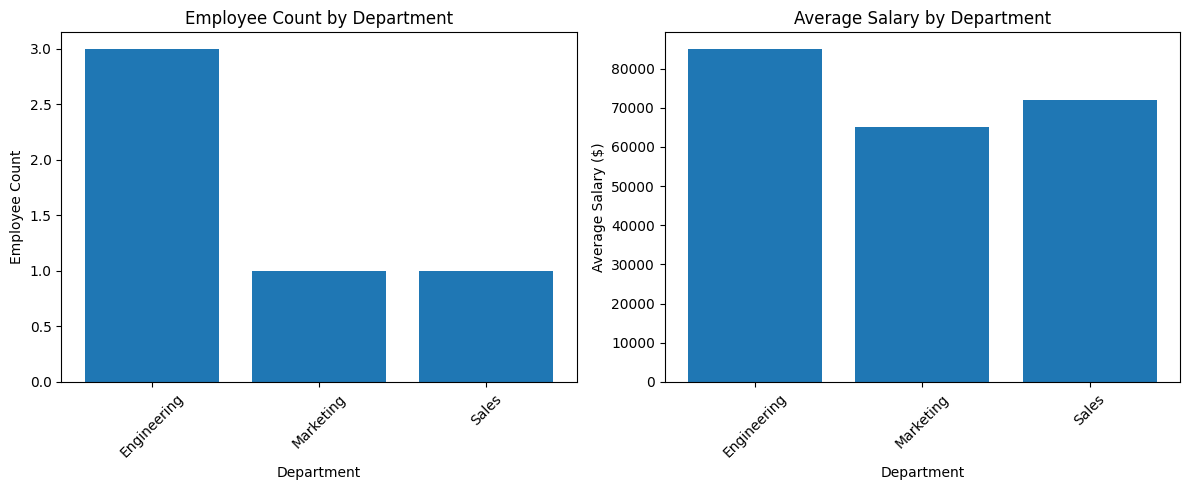

In [21]:
# Convert to Pandas for visualization
print("=== Spark to Pandas Integration ===")

# Get department statistics
dept_stats_spark = employees_df.groupBy("department").agg(
    count("*").alias("employee_count"),
    round(avg("salary"), 0).alias("avg_salary")
)

# Convert to Pandas
dept_stats_pandas = dept_stats_spark.toPandas()

print("\nDepartment statistics (Pandas):")
print(dept_stats_pandas)

# Create visualizations
plt.figure(figsize=(12, 5))

# Employee count by department
plt.subplot(1, 2, 1)
plt.bar(dept_stats_pandas['department'], dept_stats_pandas['employee_count'])
plt.title('Employee Count by Department')
plt.xlabel('Department')
plt.ylabel('Employee Count')
plt.xticks(rotation=45)

# Average salary by department
plt.subplot(1, 2, 2)
plt.bar(dept_stats_pandas['department'], dept_stats_pandas['avg_salary'])
plt.title('Average Salary by Department')
plt.xlabel('Department')
plt.ylabel('Average Salary ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Summary and Next Steps

Congratulations! You've completed the Spark DataFrames & SQL interactive tutorial. You've learned:

### Key Concepts Covered:
1. **DataFrame Creation** - From various data sources and with different schemas
2. **Basic Operations** - Select, filter, sort, and aggregate data
3. **Column Functions** - String, numeric, date, and conditional operations
4. **Spark SQL** - Using SQL syntax for complex queries
5. **Window Functions** - Advanced analytics and ranking
6. **Performance Optimization** - Caching and execution plan analysis
7. **Complex Data Types** - Arrays, maps, and nested structures
8. **Integration** - Working with Pandas and visualization

### Next Steps:
1. **Practice with Exercises** - Complete the 7 hands-on exercises
2. **Explore Solutions** - Study the provided solution files
3. **Run Tests** - Validate your understanding with the test suite
4. **Advanced Topics** - Move on to streaming, MLlib, or advanced optimizations

### Resources:
- Exercise files in the `exercises/` directory
- Solution files in the `solutions/` directory
- Test your code with `make test`
- Use `make help` to see all available commands

Happy Spark learning! 🚀

In [22]:
# Clean up
spark.stop()
print("Spark session stopped. Notebook complete!")

Spark session stopped. Notebook complete!
